# Posterior probabilities across models for MATCH study

Gaylen Fronk  
2024-06-03

## Setup

In [ ]:
version <- "v6"
cv <- "nested"
y_col_name <- "pp_hybrid_wk4_outcome"


Read in posterior probabilities for Panel B

### Code Status

In use with iterative improvement.

Updating for use with MATCH

### Notes

Can review online docs for

-   [how to use rstanarm](https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html)
-   [priors](https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html)
-   [warnings](https://mc-stan.org/misc/warnings.html)
-   [tutorial on rstanarm and shinystan](https://www.tqmp.org/RegularArticles/vol14-2/p099/p099.pdf)
-   [R Bloggers on perf_mod](https://www.r-bloggers.com/2019/12/tidyposteriors-bayesian-approach-to-model-comparison/)

### Set Up Environment

In [ ]:
study <- "match"
version <- "v6"
cv <- "nested"


Packages for script ::: {.cell}

``` r
library(tidyposterior)
library(tidyverse)
```

    ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
    ✔ dplyr     1.1.4     ✔ readr     2.1.5
    ✔ forcats   1.0.0     ✔ stringr   1.5.1
    ✔ ggplot2   3.5.1     ✔ tibble    3.2.1
    ✔ lubridate 1.9.3     ✔ tidyr     1.3.1
    ✔ purrr     1.0.2     
    ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
    ✖ dplyr::filter() masks stats::filter()
    ✖ dplyr::lag()    masks stats::lag()
    ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

``` r
library(tidymodels)
```

    ── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
    ✔ broom        1.0.5      ✔ rsample      1.2.1 
    ✔ dials        1.2.1      ✔ tune         1.2.1 
    ✔ infer        1.0.7      ✔ workflows    1.1.4 
    ✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
    ✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
    ✔ recipes      1.0.10     
    ── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
    ✖ scales::discard() masks purrr::discard()
    ✖ dplyr::filter()   masks stats::filter()
    ✖ recipes::fixed()  masks stringr::fixed()
    ✖ dplyr::lag()      masks stats::lag()
    ✖ yardstick::spec() masks readr::spec()
    ✖ recipes::step()   masks stats::step()
    • Dig deeper into tidy modeling with R at https://www.tmwr.org

``` r
theme_set(theme_classic()) 
```

:::

Absolute paths ::: {.cell}

``` r
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- "P:/studydata/match/models/"},
        
        # IOS paths
        Darwin = {
          path_models <- "/Volumes/private/studydata/match/models/"},
        
        # Linux paths
        Linux = {
          path_models <- "~/mnt/private/studydata/match/models/"}
)
```

:::

Chunk Defaults ::: {.cell .hidden}

``` r
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)
```

:::

Source training controls ::: {.cell}

``` r
# EDA
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_eda.R?raw=true")
```

    ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

:::

### Read in preds and metrics for best model

In [ ]:
auc_wk4 <- read_rds(file.path(path_models, "pp_hybrid_wk4_outcome",
                              str_c("outer_metrics_", 
                                    version, "_", cv, ".rds"))) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10), 3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc) |> 
  glimpse()


Rows: 30
Columns: 3
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ roc_auc    <dbl> 0.6228433, 0.7275495, 0.7171286, 0.6581779, 0.7284903, 0.70…

Rows: 30
Columns: 3
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ roc_auc    <dbl> 0.5856164, 0.7572374, 0.6553749, 0.5708861, 0.6875000, 0.76…

Rows: 30
Columns: 3
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ roc_auc    <dbl> 0.6000000, 0.6578652, 0.6319048, 0.5597776, 0.6696203, 0.65…

Rows: 30
Columns: 5
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ week_4     <dbl> 0.6228433, 0.7275495, 0.7171286, 0.6581779, 0.7284903, 0.70…
$ week_12    <dbl> 0.5856164, 0.7572374, 0.6553749, 0.5708861, 0.6875000, 0.76…
$ week_26    <dbl> 0.6000000, 0.6578652, 0.6319048, 0.5597776, 0.6696203, 0.65…

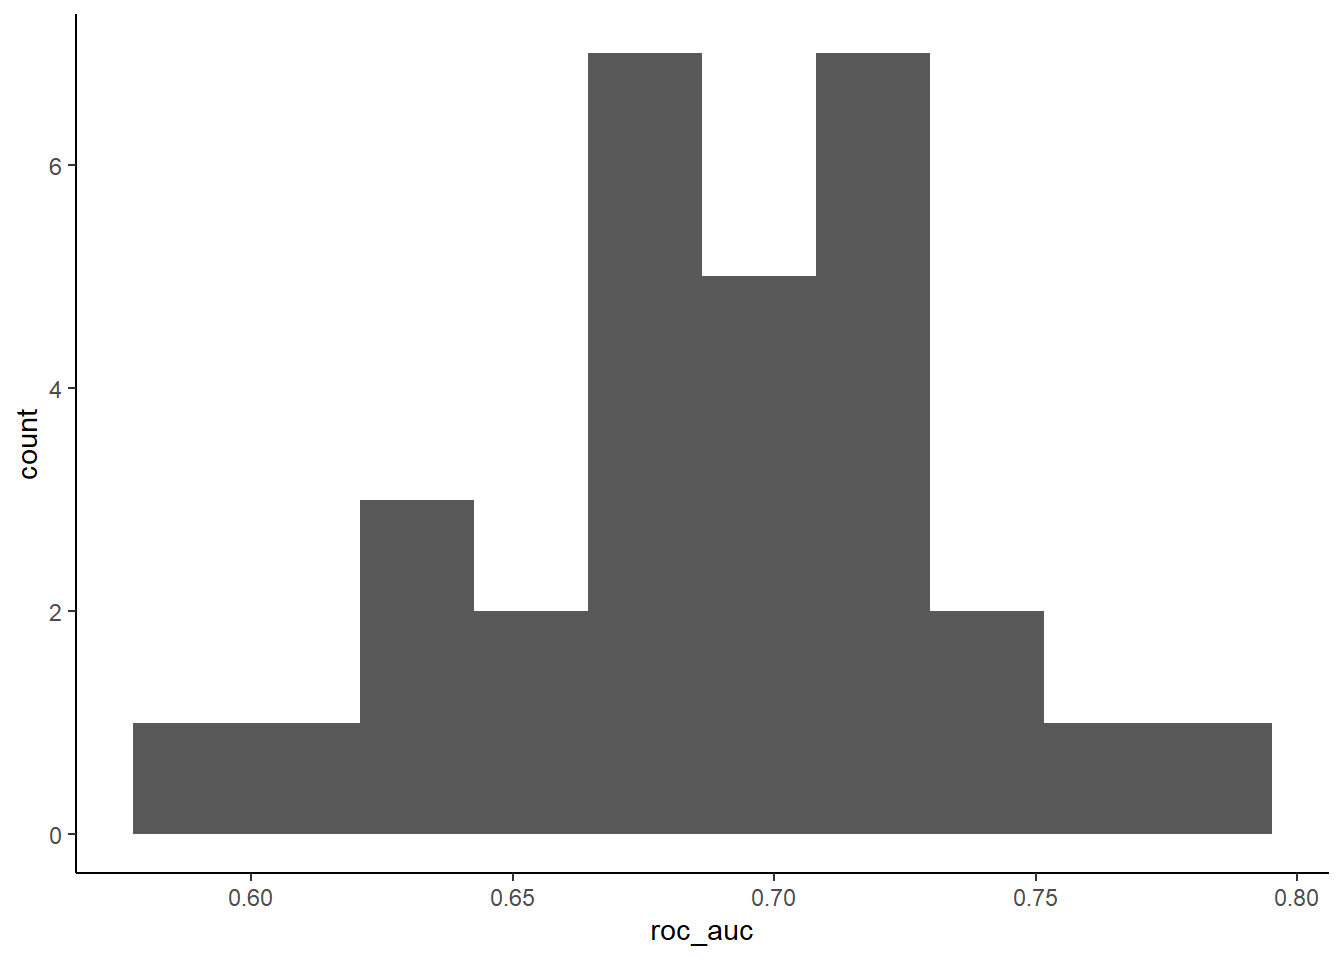

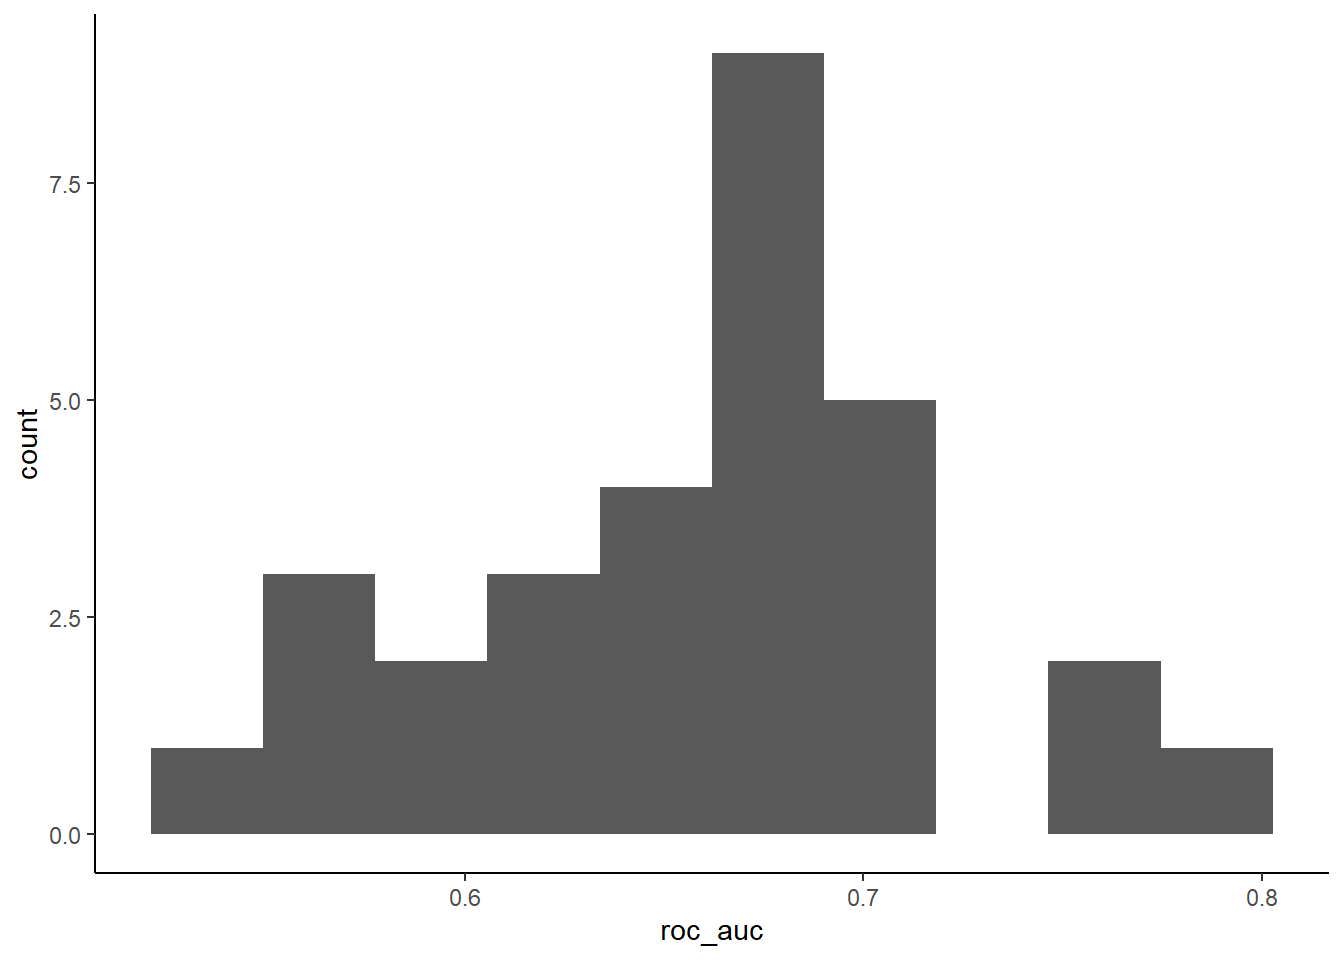

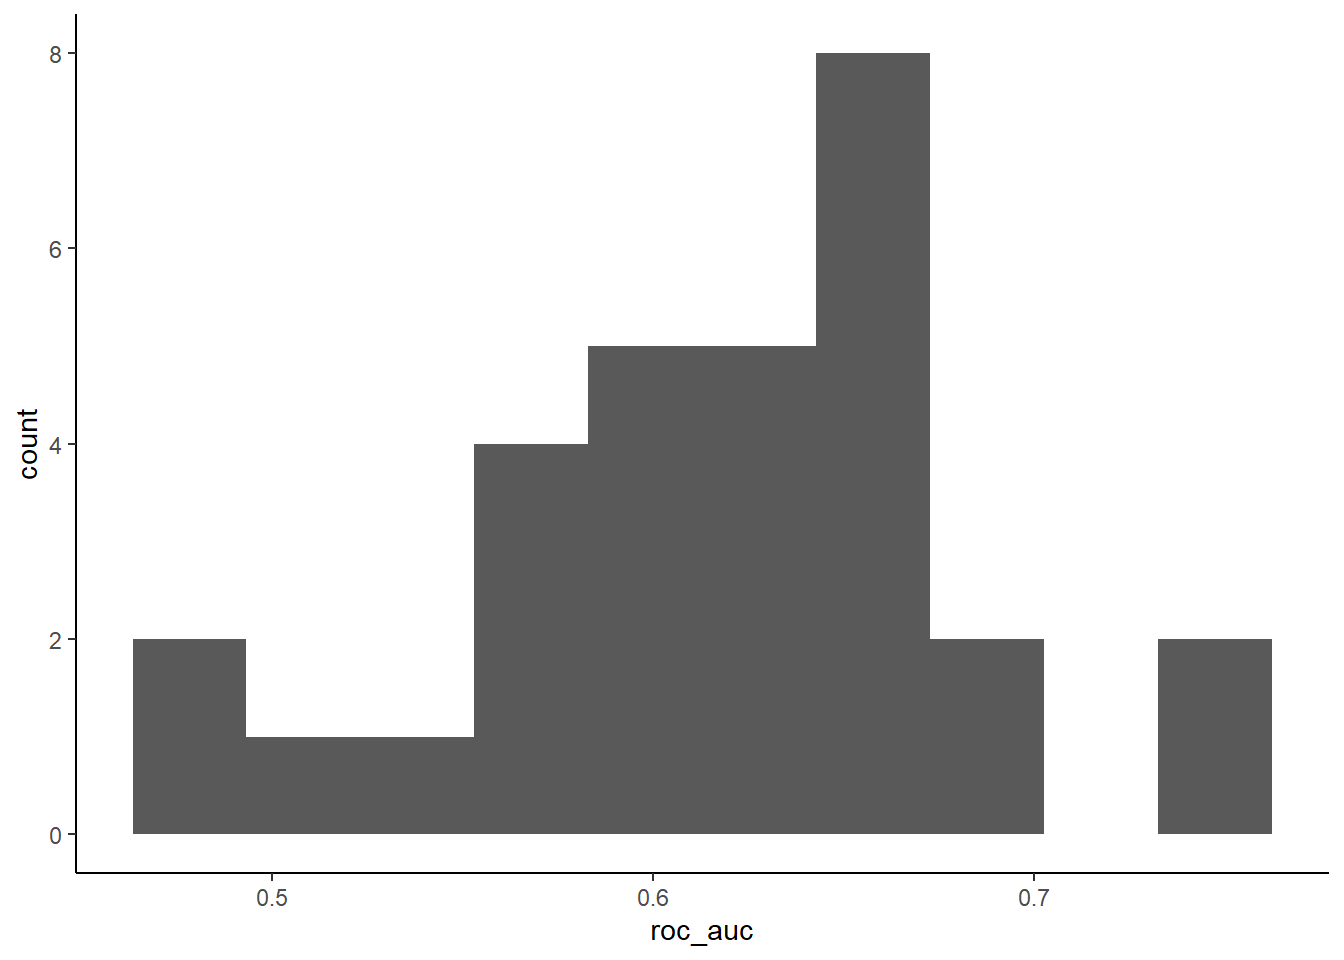

In [ ]:
auc_wk4 %>% 
  ggplot() + 
  geom_histogram(aes(x = roc_auc), bins = 10)


### All models

In [ ]:
# from ?perf_mod()
# Repeated CV (id = repeat, id2 = fold within repeat)

set.seed(101)
pp <- auc |> 
  rename(id = repeat_num,
         id2 = fold_num) |> 
  perf_mod(formula = statistic ~ model + (1 | id2/id), 
           # prior_intercept = rstanarm::student_t(autoscale = TRUE),
           # prior = rstanarm::student_t(autoscale = TRUE),
           transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
           iter = 2000, chains = 4,  
           adapt_delta = .999,
           # cores = 4, seed = 12345,
           family = gaussian, 
  )  



SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.318 seconds (Warm-up)
Chain 1:                0.991 seconds (Sampling)
Chain 1:                3.30

In [ ]:
rstanarm::prior_summary(pp$stan)


Priors for model 'pp$stan' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 0.66, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0.66, scale = 0.71)

Coefficients
  Specified prior:
    ~ normal(location = [0,0], scale = [2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0], scale = [1.51,1.51])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 3.5)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

In [ ]:
summary(pp$stan)



Model Info:
 function:     stan_glmer
 family:       gaussian [identity]
 formula:      statistic ~ model + (1 | id2/id)
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 90
 groups:       id:id2 (30), id2 (10)

Estimates:
                                        mean   sd   10%   50%   90%
(Intercept)                            0.7    0.1  0.6   0.7   0.7 
modelweek_26                          -0.2    0.0 -0.2  -0.2  -0.1 
modelweek_4                            0.1    0.0  0.1   0.1   0.2 
b[(Intercept) id:id2:repeat1:fold1]   -0.2    0.1 -0.3  -0.2   0.0 
b[(Intercept) id:id2:repeat1:fold10]   0.0    0.1 -0.1   0.0   0.1 
b[(Intercept) id:id2:repeat1:fold2]    0.2    0.1  0.1   0.2   0.3 
b[(Intercept) id:id2:repeat1:fold3]    0.0    0.1 -0.1   0.0   0.2 
b[(Intercept) id:id2:repeat1:fold4]   -0.2    0.1 -0.3  -0.2  -0.1 
b[(Intercept) id:id2:repeat1:fold5]    0.1    0.1  0.0   0.1   0.2 
b[(Intercept) id:id2:r

In [ ]:
# shinystan::launch_shinystan(pp$stan)


In [ ]:
pp %>%  write_rds(file.path(path_models, 
                            str_c("posteriors_", version, "_nested.rds")))


### Model posterier CIs

In [ ]:
pp_tidy <- pp %>% 
  tidy(seed = 123)

q = c(.025, .5, .975)
pp_tidy |> 
  group_by(model) |> 
  summarize(median = quantile(posterior, probs = q[2]),
            lower = quantile(posterior, probs = q[1]), 
            upper = quantile(posterior, probs = q[3])) |> 
  mutate(model = factor(model, levels = c("week_26", "week_12", "week_4"),
                        labels = c("Week 26", "Week 12", "Week 4")),
         y = 1000) |> 
  arrange(model)


# A tibble: 3 × 5
  model   median lower upper     y
  <fct>    <dbl> <dbl> <dbl> <dbl>
1 Week 26  0.620 0.596 0.644  1000
2 Week 12  0.663 0.640 0.685  1000
3 Week 4   0.693 0.670 0.715  1000

### Model contrasts

# A tibble: 3 × 9
  contrast           probability   mean  lower  upper  size pract_neg
  <chr>                    <dbl>  <dbl>  <dbl>  <dbl> <dbl>     <dbl>
1 week_12 vs week_26       1     0.0426 0.0215 0.0635  0.01         0
2 week_4 vs week_12        0.998 0.0295 0.0102 0.0494  0.01         0
3 week_4 vs week_26        1     0.0721 0.0522 0.0923  0.01         0
  pract_equiv pract_pos
        <dbl>     <dbl>
1     0.00175     0.998
2     0.0245      0.976
3     0           1    

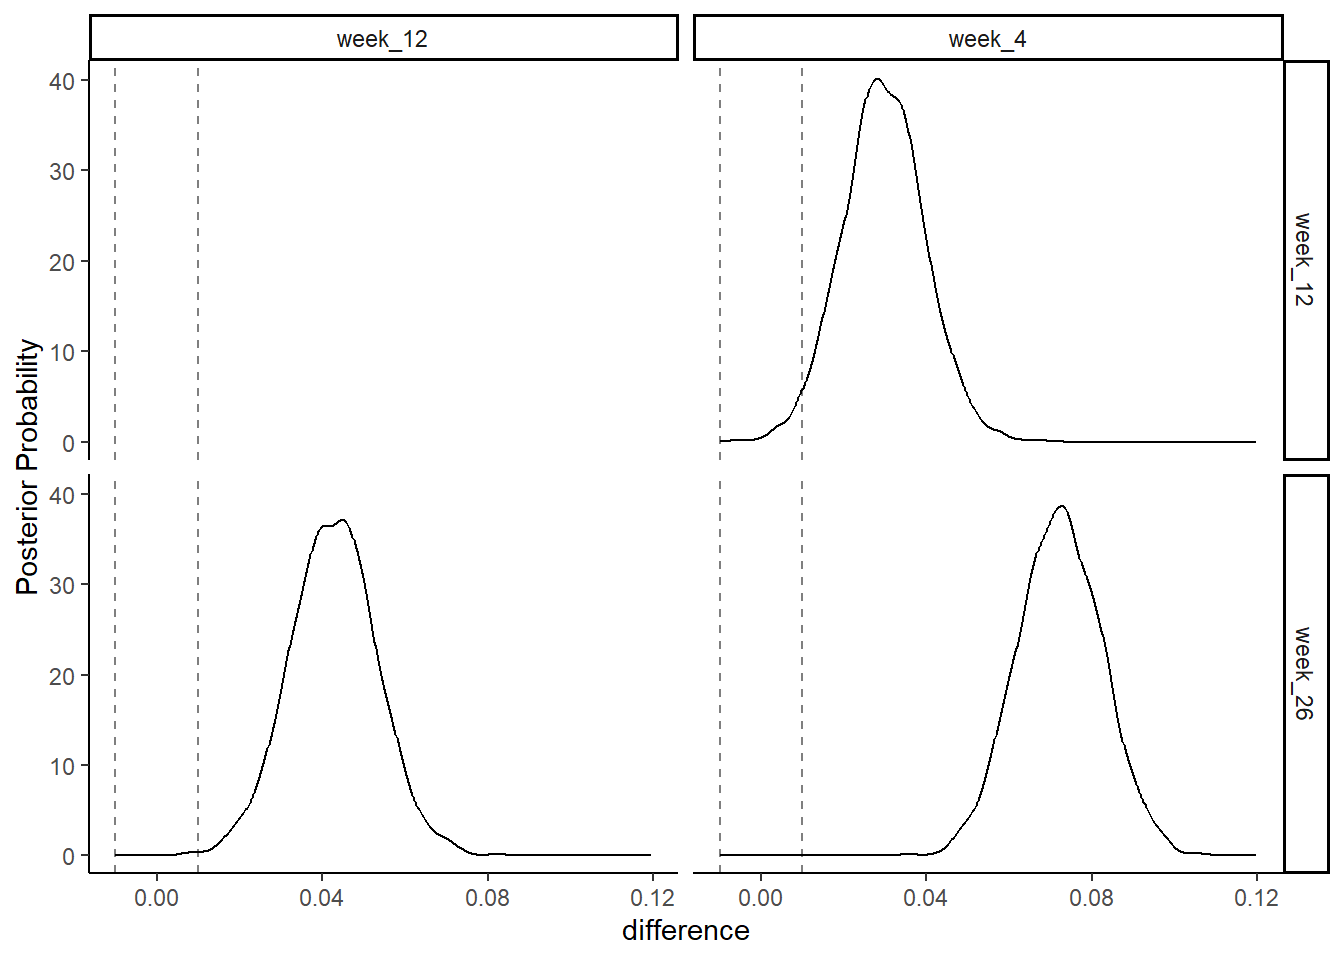

In [ ]:
pp_contrasts <- contrast_models(pp, 
                                list("week_4", "week_4", "week_12"), 
                                list("week_12", "week_26", "week_26"))
summary(pp_contrasts, size = .01, prob = 0.95)


Here are contrasts against 0 rather than using ROPE ::: {.cell}

``` r
pp_contrasts |> 
  filter(contrast == "week_4 vs. week_12") |> 
  mutate(wk4_gt_wk12 = if_else(difference > 0, 1, 0)) |>
  pull(wk4_gt_wk12) |> 
  mean()
```

```
[1] 0.9985
```

``` r
pp_contrasts |> 
  filter(contrast == "week_4 vs. week_26") |> 
  mutate(wk4_gt_wk26 = if_else(difference > 0, 1, 0)) |>
  pull(wk4_gt_wk26) |> 
  mean()
```

```
[1] 1
```

``` r
pp_contrasts |> 
  filter(contrast == "week_12 vs. week_26") |> 
  mutate(wk12_gt_wk26 = if_else(difference > 0, 1, 0)) |>
  pull(wk12_gt_wk26) |> 
  mean()
```

```
[1] 1
```

:::

### Plots

Model posteriors ::: {.cell}

``` r
ci <- pp_tidy |> 
  summary() |> 
  mutate(model = factor(model, levels = c("week_4", "week_12", "week_26"),
                        labels = c("Week 4", "Week 12", "Week 26")),
         y = 1000) 
```

:::

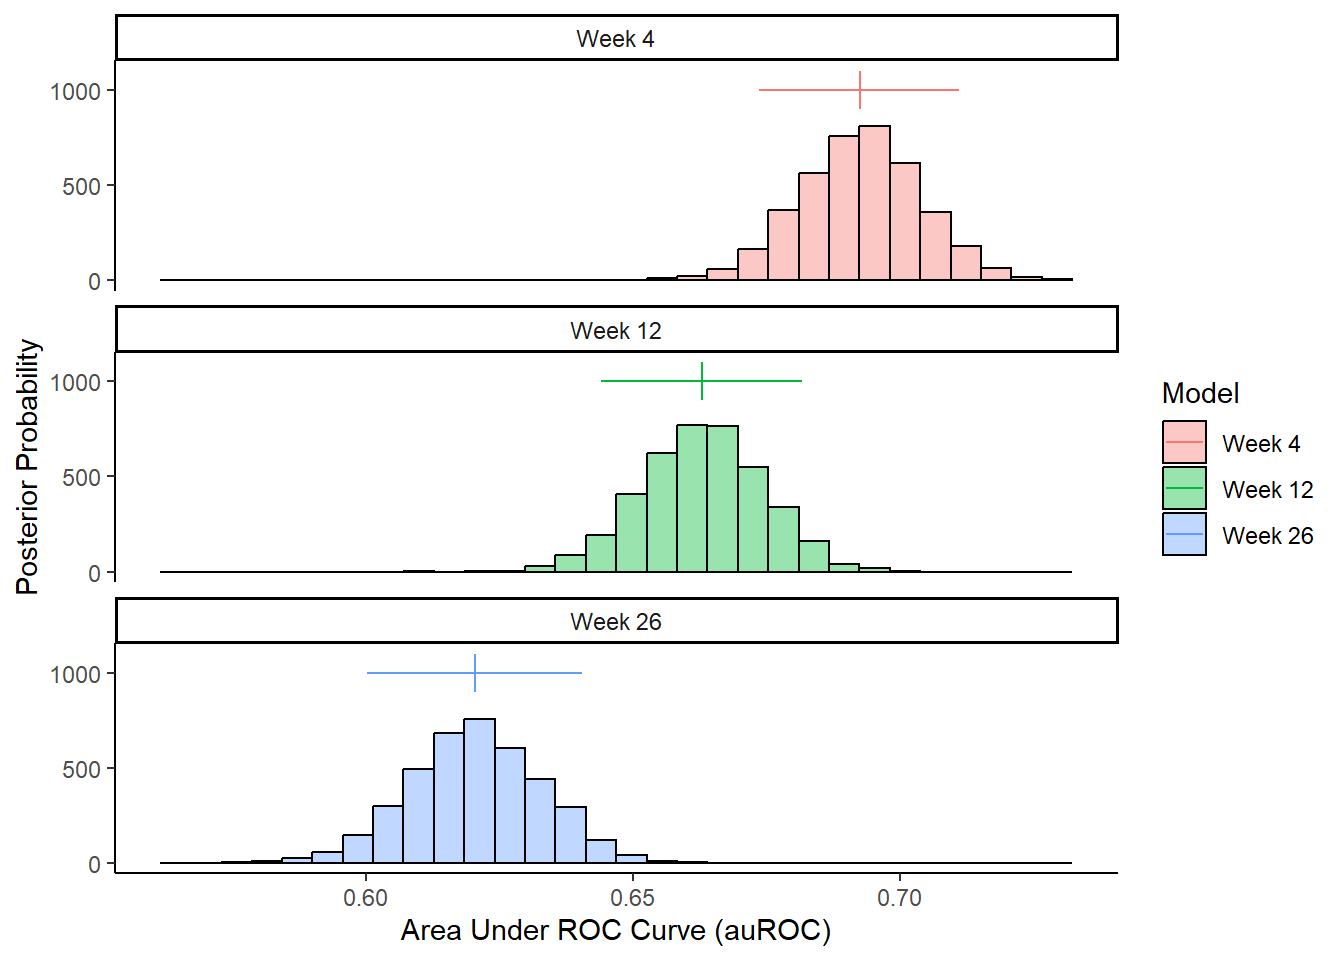

In [ ]:
fig_posteriors <- pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_12", "week_26"),
                        labels = c("Week 4", "Week 12", "Week 26"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y + 100, yend = y - 100, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, 
                             x = lower, xend = upper, color = model),
               data = ci) +
  facet_wrap(~model, ncol = 1) +
  scale_y_continuous("Posterior Probability", breaks = c(0, 500, 1000)) +
  labs(
    x = "Area Under ROC Curve (auROC)",
    fill = "Model",
    color = "Model"
  )

fig_posteriors


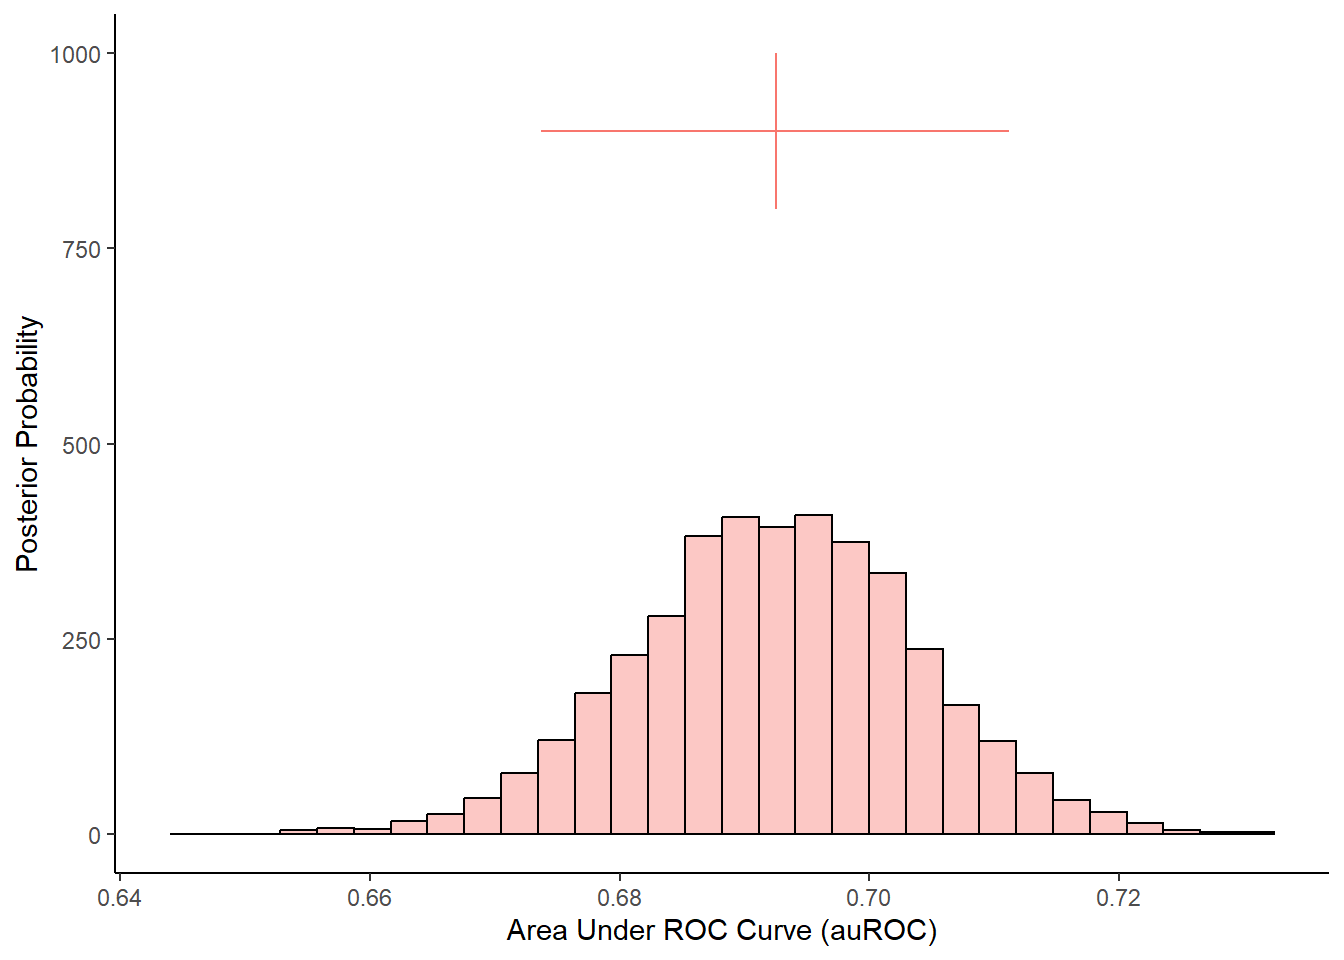

In [ ]:

ci_week4 <- ci |> 
  filter(model == "Week 4")

pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_12", "week_26"),
                        labels = c("Week 4", "Week 12", "Week 26"))) |> 
  filter(model == "Week 4") |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y, yend = y - 200, x = mean, xend = mean,
                             color = model),
               data = ci_week4) +
  geom_segment(mapping = aes(y = y - 100, yend = y - 100, 
                             x = lower, xend = upper, color = model),
               data = ci_week4) +
  scale_y_continuous("Posterior Probability") +
  labs(
    x = "Area Under ROC Curve (auROC)",
  ) +
  theme(legend.position = "none")


model contrast posteriors

In [ ]:
ci_con <- pp |>
  contrast_models(list("week_4", "week_4", "week_12"), 
                  list("week_12", "week_26", "week_26")) |> 
  summary(size = .01) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("week_4 vs week_12",
                                      "week_4 vs week_26",
                                      "week_12 vs week_26"),
                           labels = c("Week 4 vs. Week 12",
                                      "Week 4 vs. Week 26",
                                      "Week 12 vs. Week 26")),
         y = 800)


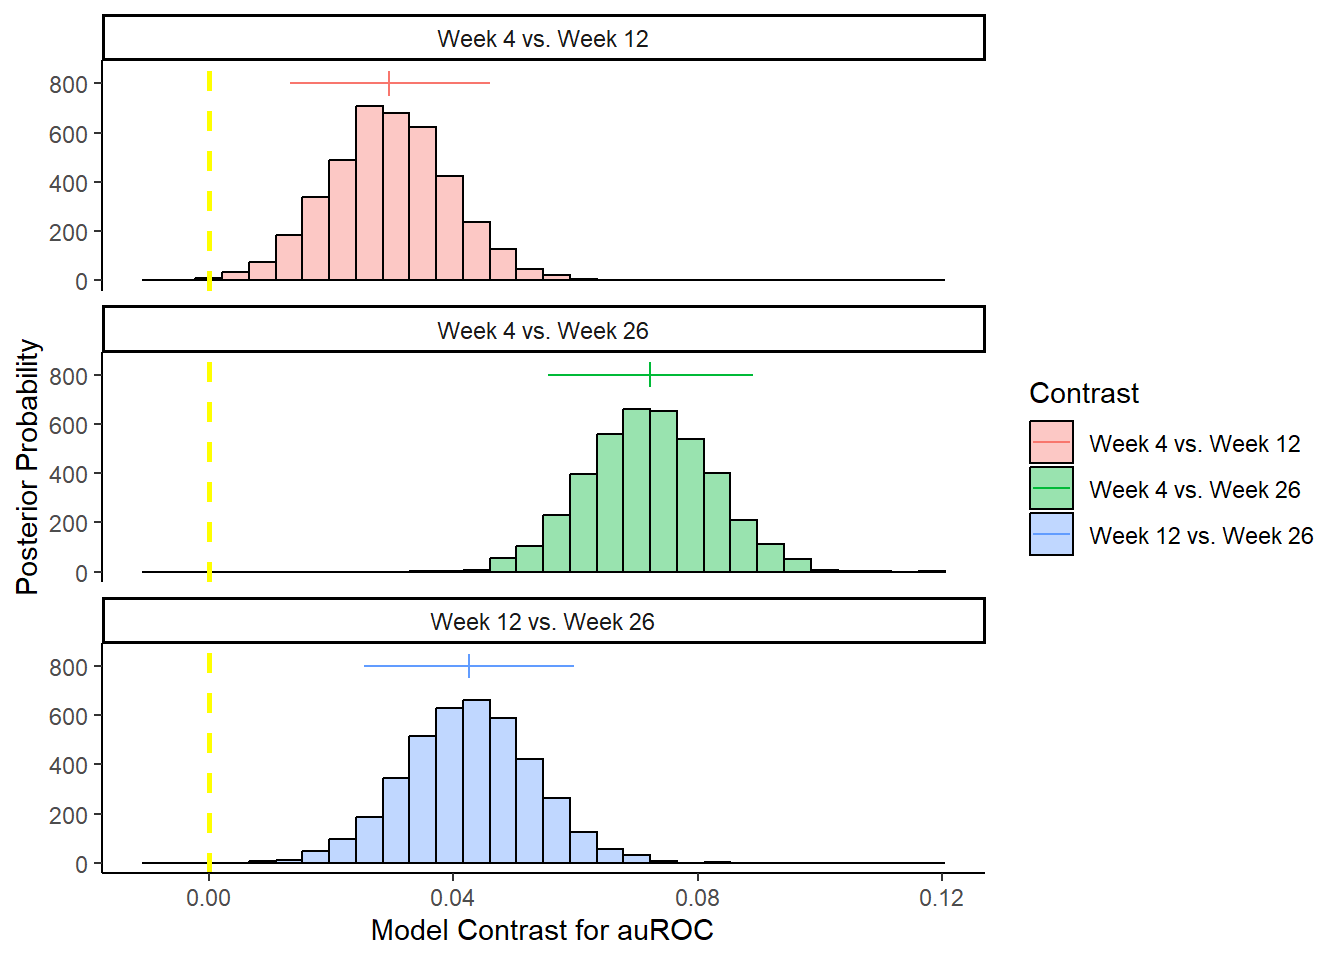

In [ ]:

fig_contrasts <- pp |> 
  tidy(seed = 123) |>   
  group_by(model) |> 
  mutate(sample = row_number()) |> 
  ungroup() |> 
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(wk4_vs_wk26 = week_4 - week_26,
         wk4_vs_wk12 = week_4 - week_12,
         wk12_vs_wk26 = week_12 - week_26) |> 
  pivot_longer(cols = c(wk4_vs_wk12, wk4_vs_wk26, wk12_vs_wk26),
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast,
                           levels = c("wk4_vs_wk12", "wk4_vs_wk26", "wk12_vs_wk26"),
                           labels = c("Week 4 vs. Week 12",
                                      "Week 4 vs. Week 26",
                                      "Week 12 vs. Week 26"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior, fill = contrast), 
                 color = "black", alpha = .4, bins = 30) +
  geom_vline(xintercept = 0, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_segment(mapping = aes(y = y+50, yend = y-50, 
                             x = mean, xend = mean, color = contrast), 
               data = ci_con) +
  geom_segment(mapping = aes(y = y, yend = y, 
                             x = lower, xend = upper, color = contrast), 
               data = ci_con) +
  facet_wrap(~contrast, ncol = 1) +
  labs(
    x = "Model Contrast for auROC",
    y = "Posterior Probability",
    fill = "Contrast",
    color = "Contrast"
  )

fig_contrasts


In [ ]:

# packages for script
library(tidyverse)
library(tidymodels)
library(tidyposterior)
library(probably)



Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- str_c("P:/studydata/match/models/", 
                               y_col_name)
        },
        
        # IOS paths
        Darwin = {
          path_models <- str_c("/Volumes/private/studydata/match/models/",
                               y_col_name)
        },
        
        # Linux paths
        Linux = {
          path_models <- str_c("~/mnt/private/studydata/match/models/",
                               y_col_name)
        }
)


In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)


## Make Panels

### Panel A: ROC Curve

Read in outer loop predictions

In [ ]:
preds_out <- read_rds(file.path(path_models, 
                                str_c("outer_preds_", version, 
                                      "_", cv, ".rds"))) |> 
  glimpse()


Rows: 3,258
Columns: 3
$ outer_split_num <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.1909314, 0.4794358, 0.3849448, 0.2902418, 0.3972917,…
$ label           <fct> smoking, smoking, smoking, smoking, abstinent, abstine…

Set up data

In [ ]:
roc_data <- preds_out %>%
  roc_curve(prob_raw, truth = label) |> 
  glimpse()


Rows: 3,260
Columns: 3
$ .threshold  <dbl> -Inf, 0.007374031, 0.010426309, 0.015869775, 0.016545182, …
$ specificity <dbl> 0.0000000000, 0.0000000000, 0.0004662005, 0.0009324009, 0.…
$ sensitivity <dbl> 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0…

Create plot

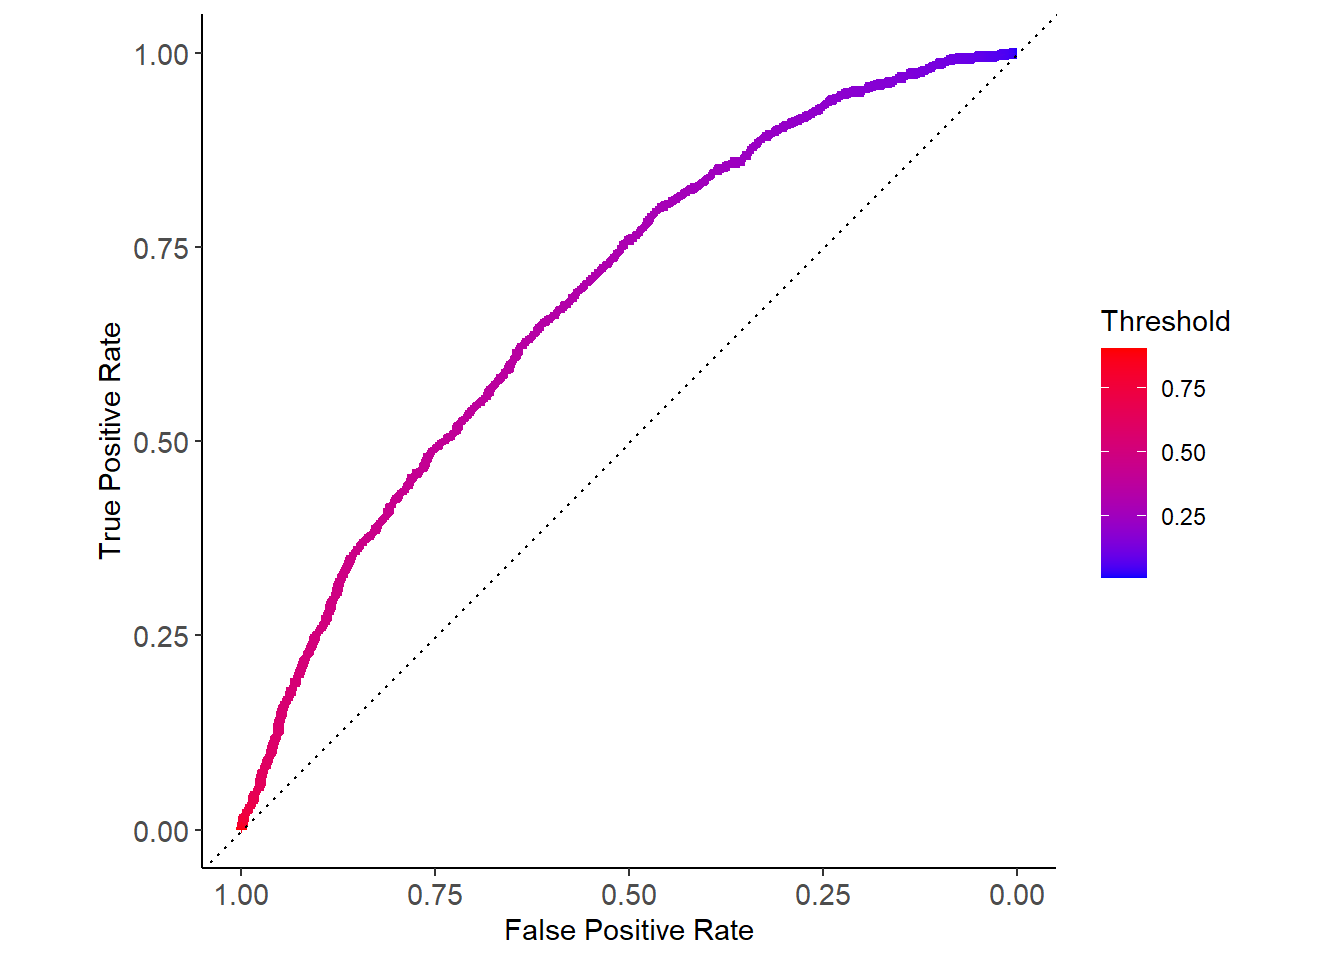

In [ ]:

fig_roc <- roc_data %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity, color = .threshold)) +
  geom_path(linewidth = 2) +
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "False Positive Rate",
       y = "True Positive Rate",
       color = "Threshold") +
  scale_x_continuous(breaks = seq(0,1,.25),
                     labels = sprintf("%.2f", seq(1,0,-.25))) +
  scale_color_gradient(low="blue", high="red") +
  theme(axis.text = element_text(size = rel(1)),
        axis.title = element_text(size = rel(1)))

fig_roc


### Panel B: Posterior Probability Distribution

Read in posteriors

In [ ]:
pp <- read_rds(file.path("P:/studydata/match/models/", 
                         str_c("posteriors_", version, "_nested.rds")))


Set up data

In [ ]:
pp_tidy <- pp |> 
  tidy(seed = 123) |> 
  glimpse()


Rows: 12,000
Columns: 2
$ model     <chr> "week_4", "week_12", "week_26", "week_4", "week_12", "week_2…
$ posterior <dbl> 0.6903614, 0.6647075, 0.6292686, 0.6942714, 0.6666706, 0.610…

Create plot

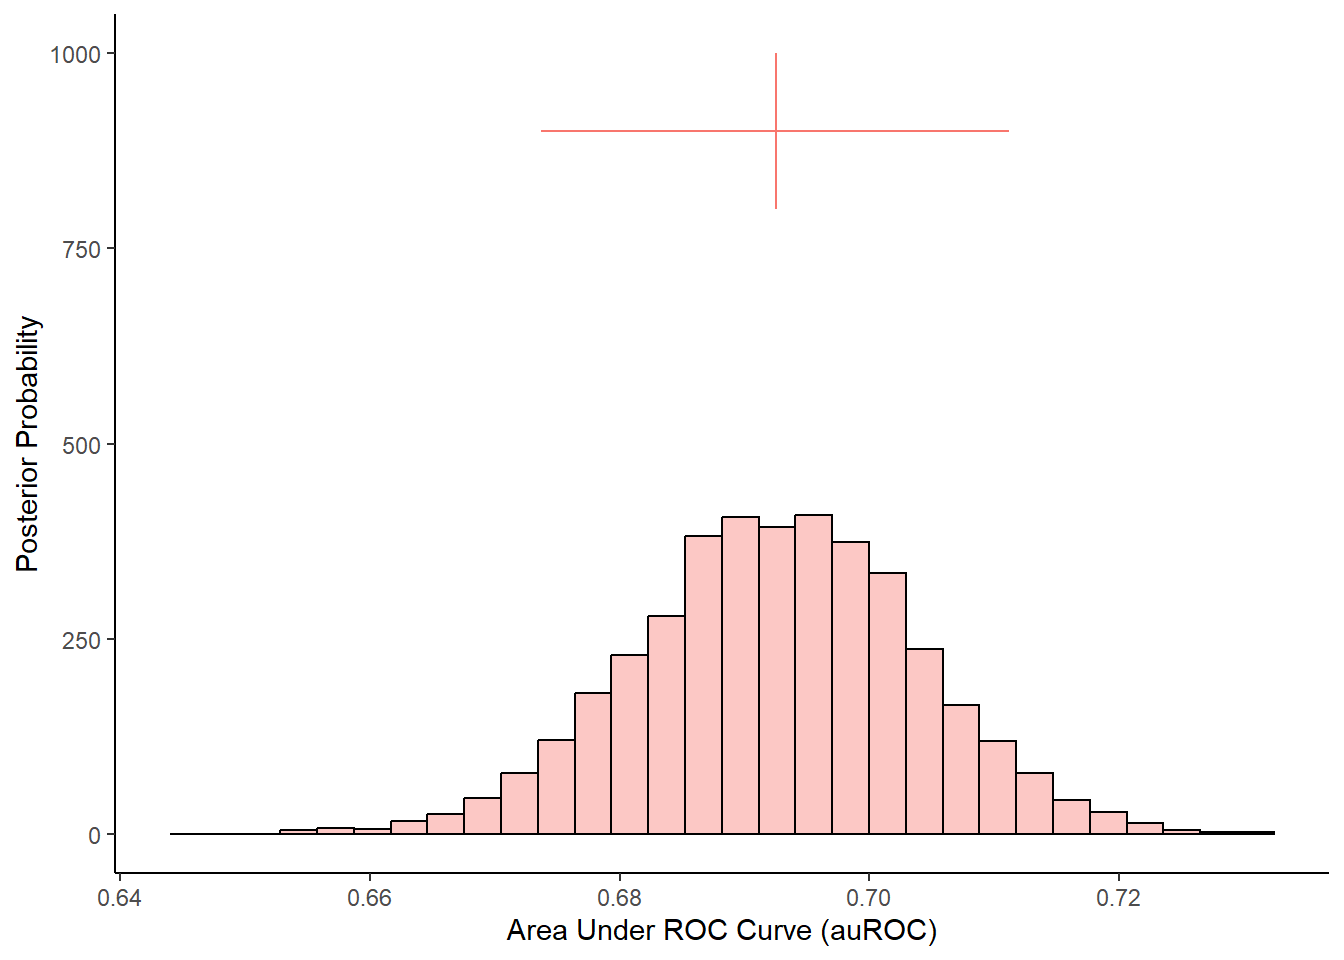

In [ ]:

fig_pp <- pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_12", "week_26"),
                        labels = c("Week 4", "Week 12", "Week 26"))) |> 
  filter(model == "Week 4") |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y, yend = y - 200, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y - 100, yend = y - 100, 
                             x = lower, xend = upper, color = model),
               data = ci) +
  scale_y_continuous("Posterior Probability") +
  labs(
    x = "Area Under ROC Curve (auROC)",
  ) +
  theme(legend.position = "none")

fig_pp


### Panel C: Prediction Calibration

Read in final model predictions (LOOCV)

In [ ]:
d_cal <- read_csv(file.path(path_models,
                            str_c("aim_2_", version, "_", y_col_name, ".csv")),
                  show_col_types = FALSE) |> 
  glimpse()


Rows: 1,086
Columns: 11
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <chr> "patch", "combo_nrt", "patch", "varenicline", "patch"…
$ tx_best          <chr> "varenicline", "varenicline", "combo_nrt", "varenicli…
$ tx_match         <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, TRUE, FALSE, FALSE,…
$ prob_best        <dbl> 0.2799119, 0.5102584, 0.3089657, 0.4553562, 0.4605510…
$ outcome_rct_wk4  <chr> "smoking", "smoking", "smoking", "smoking", "smoking"…
$ outcome_rct_wk12 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ prob_patch       <dbl> 0.2080906, 0.4220443, 0.2330746, 0.3961983, 0.3172879…
$ prob_combo_nrt   <dbl> 0.1754414, 0.4957828, 0.3089657, 0.4056079, 0.4605510…
$ prob_varenicline <dbl> 0.2799119, 0.5102584, 0.2883452, 0.4553562, 0.4409814…

Set up data

In [ ]:
d_cal <- d_cal |> 
  mutate(.pred_abstinent = case_when(
    tx_rct == "patch" ~ prob_patch,
    tx_rct == "combo_nrt" ~ prob_combo_nrt,
    tx_rct == "varenicline" ~ prob_varenicline,
    TRUE ~ NA_real_
  )) |> 
  select(outcome_rct = outcome_rct_wk4, .pred_abstinent) |> 
  mutate(outcome_rct = factor(outcome_rct,
                              levels = c("abstinent", "smoking"))) |> 
  glimpse()


Rows: 1,086
Columns: 2
$ outcome_rct     <fct> smoking, smoking, smoking, smoking, smoking, smoking, …
$ .pred_abstinent <dbl> 0.2080906, 0.4957828, 0.2330746, 0.4553562, 0.3172879,…

Created binned plot

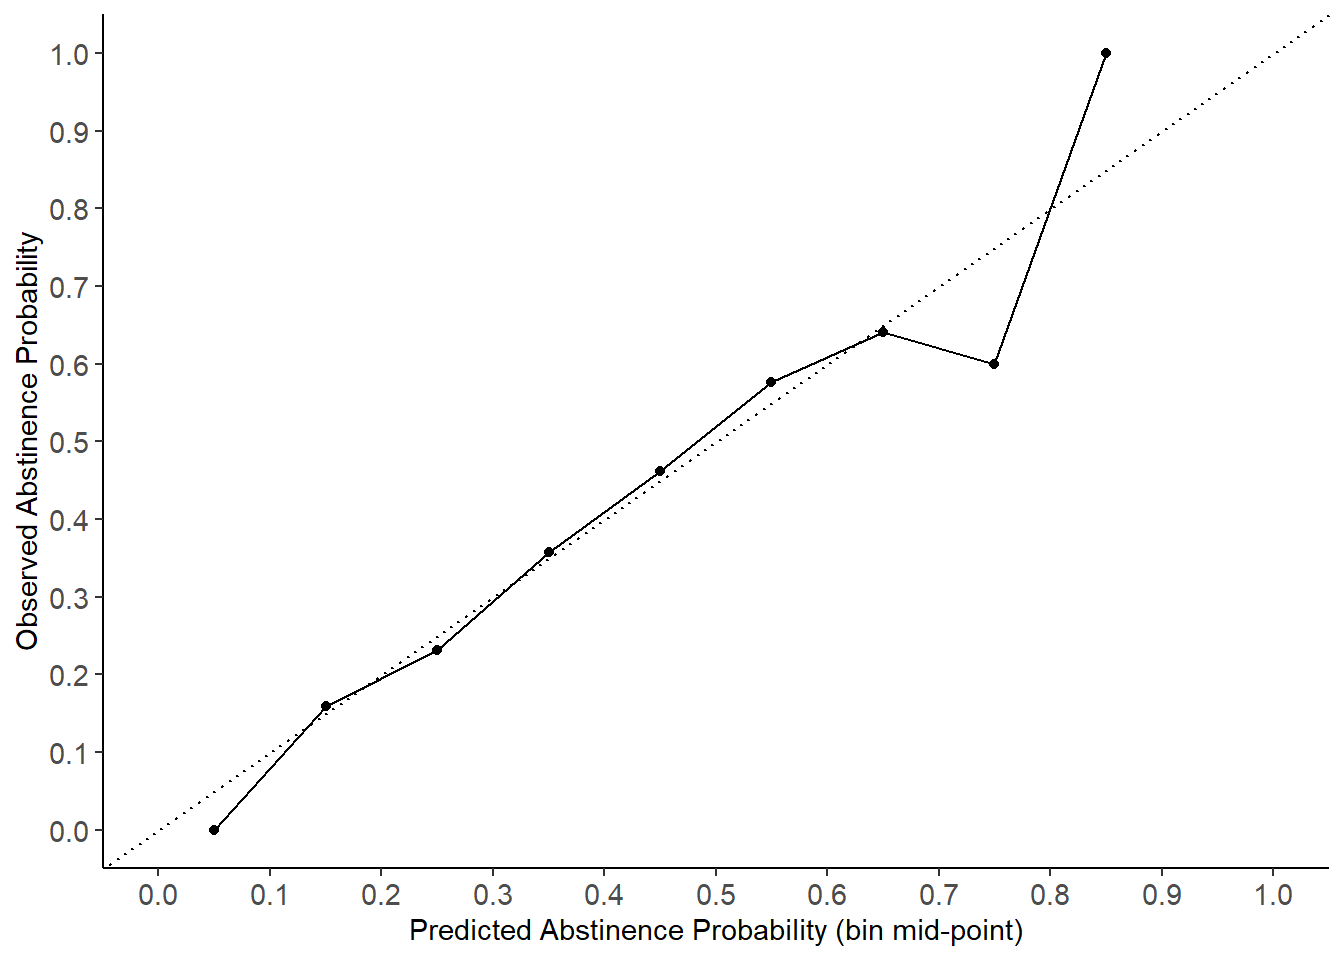

In [ ]:

bin_width = 0.10

fig_cal_bins <- d_cal |> 
  rename(prob_raw = .pred_abstinent) |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)),
         abstinent = if_else(outcome_rct == "abstinent", 1, 0)) |> 
  group_by(bins)  |> 
  summarize(mean_abstinent = mean(abstinent),
            .groups = "drop") |>
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_abstinent)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  xlab("Predicted Abstinence Probability (bin mid-point)") +
  ylab("Observed Abstinence Probability") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  theme(axis.text = element_text(size = rel(1)),
        axis.title = element_text(size = rel(1)))

fig_cal_bins


## Combine into single figure

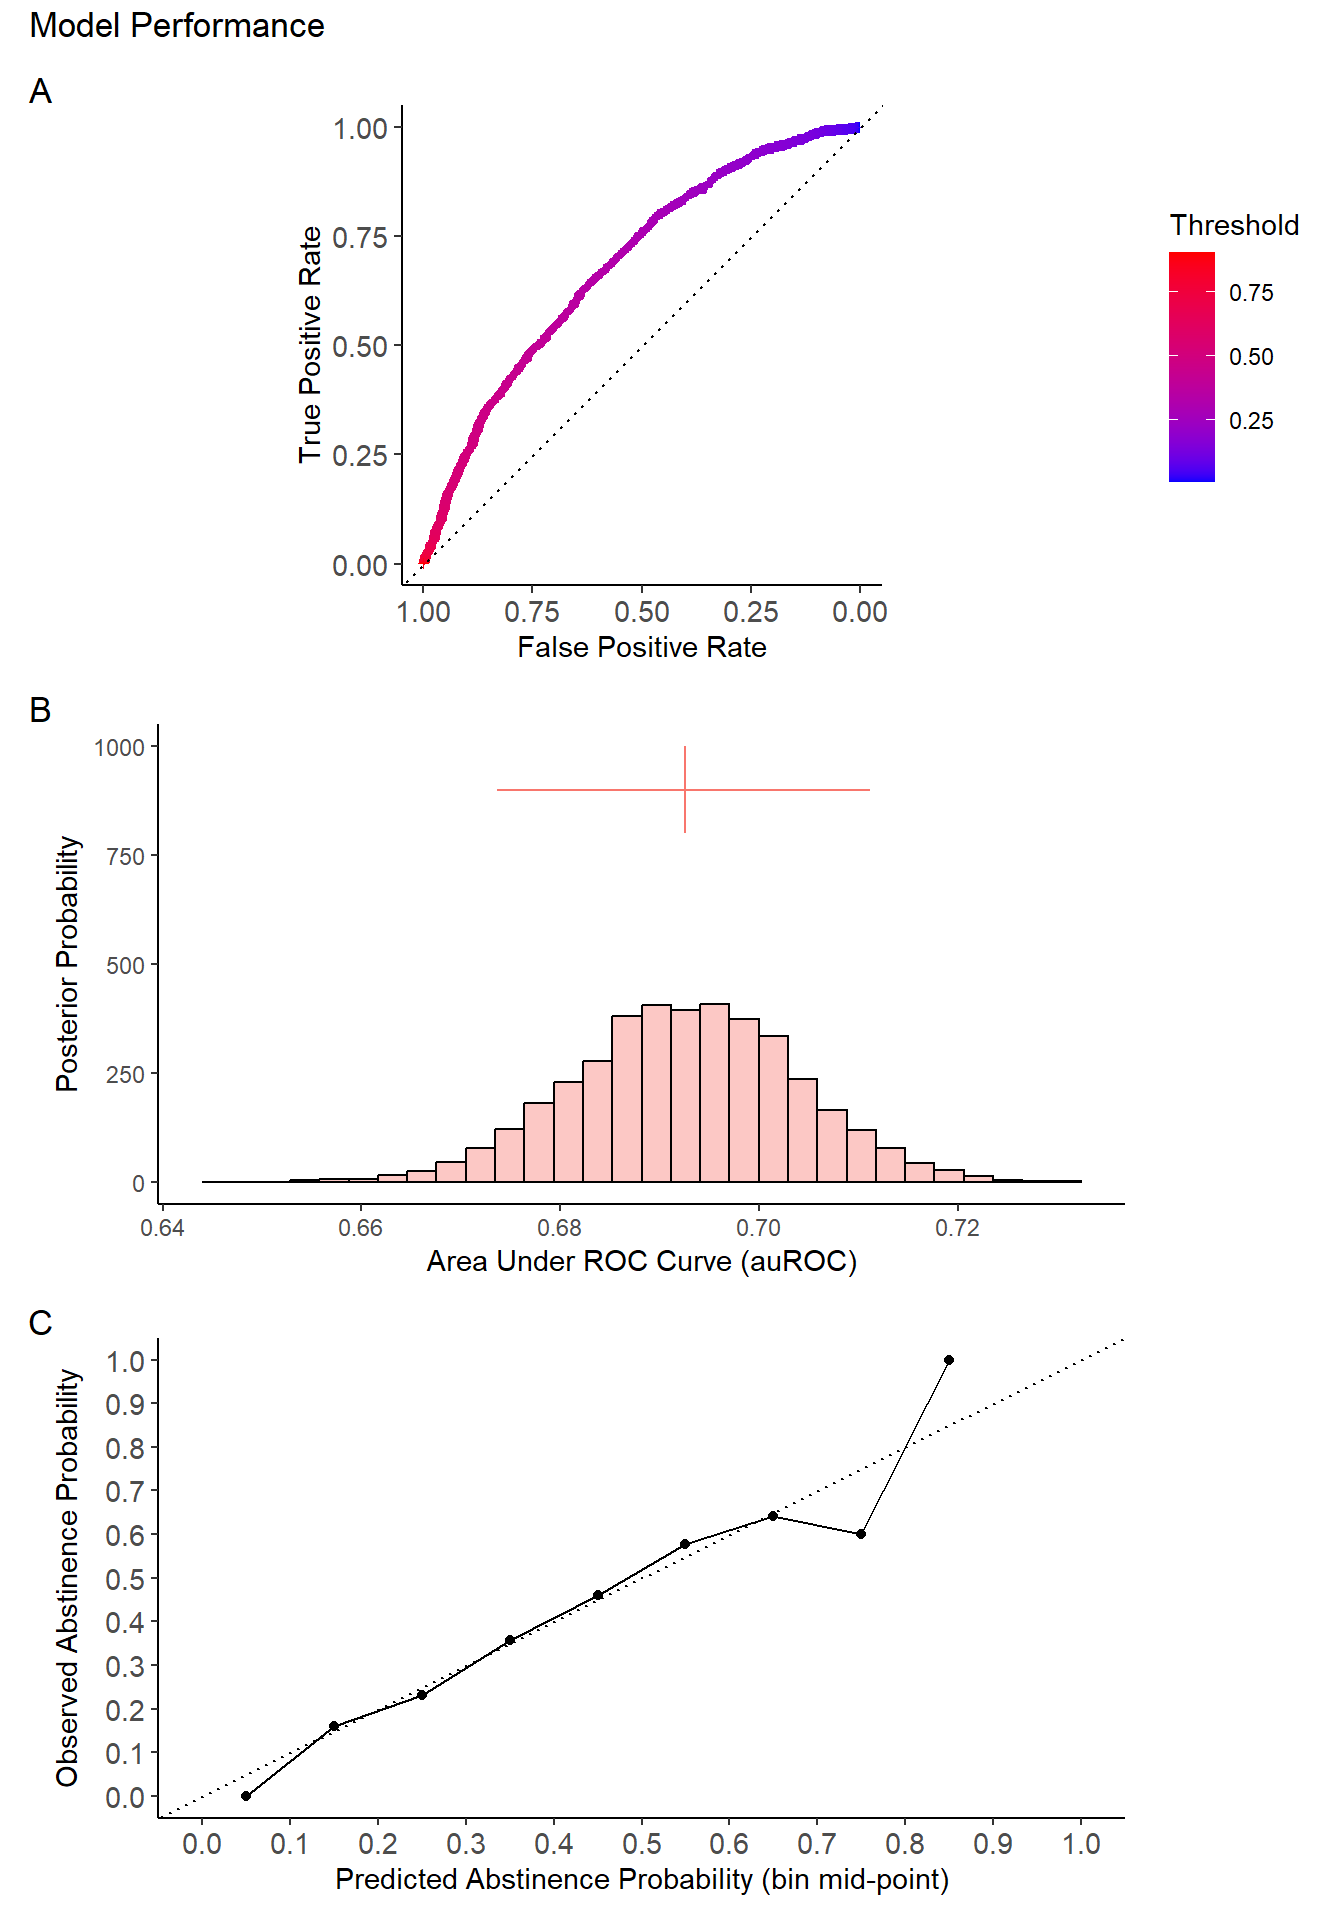

In [ ]:

patchwork <- fig_roc + fig_pp + fig_cal_bins 

patchwork + plot_annotation(
  title = "Model Performance",
  tag_levels = c("A", "B", "C")
) +
  plot_layout(ncol = 1, heights = unit(c(2.5,2.5,2.5), 'in'))
